In [112]:
import os
from os.path import join
import re
import pickle

from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from vowpalwabbit.DFtoVW import DFtoVW
from vowpalwabbit.pyvw import vw

# Graphical
SUPTITLE_FONTSIZE = 20
SUPTITLE_FONTWEIGHT = "bold"
TITLE_FONTSIZE = 15

from utils import default_feature_str, default_feature_str, get_test_example, get_vw_examples, get_training_example

## Prepare the datasert in the vowpalwabbit format

In [113]:
feature_names =["Num token","Num char","Avg word length","Num ADJ","Num ADP","Num ADV","Num AUX","Num CCONJ","Num DET","Num INTJ","Num NOUN","Num NUM","Num PART","Num PRON","Num PROPN","Num PUNCT","Num SCONJ","Num SYM","Num VERB","Num X","Num LOC","Num MISC","Num ORG","Num PER","Num Abbr=Yes","Num Case=Acc","Num Case=Nom","Num Definite=Def","Num Definite=Ind","Num Degree=Cmp","Num Degree=Pos","Num Degree=Sup","Num Foreign=Yes","Num Gender=Fem","Num Gender=Masc","Num Gender=Neut","Num Mood=Imp","Num Mood=Ind","Num NumForm=Digit","Num NumForm=Word","Num NumType=Card","Num NumType=Mult","Num NumType=Ord","Num Number=Plur","Num Number=Sing","Num Person=1","Num Person=2","Num Person=3","Num Polarity=Neg","Num Poss=Yes","Num PronType=Art","Num PronType=Dem","Num PronType=Int","Num PronType=Prs","Num PronType=Rel","Num Reflex=Yes","Num Tense=Past","Num Tense=Pres","Num VerbForm=Fin","Num VerbForm=Ger","Num VerbForm=Inf","Num VerbForm=Part","Num Voice=Pass","Num Style=Expr","Num NumForm=Roman","Num Mood=Cnd","Num Mood=Sub","Num Number[psor]=Plur","Num Number[psor]=Sing","Num Person[psor]=1","Num Person[psor]=2","Num Person[psor]=3","Num PronType=Exc","Num PronType=Ind","Num PronType=Neg","Num Tense=Fut","Num Tense=Imp","Num Typo=Yes","Num Case=Dat","Num Case=Gen","Num Gender[psor]=Masc,Neut","Num Animacy=Anim","Num Animacy=Inan","Num Aspect=Imp","Num Aspect=Perf","Num Case=Ins","Num Case=Loc","Num Variant=Short","Num VerbForm=Conv","Num Voice=Act","Num Voice=Mid","Num AdpType=Comprep","Num AdpType=Prep","Num AdpType=Voc","Num Case=Voc","Num ConjType=Oper","Num Gender=Fem,Masc","Num Gender=Fem,Neut","Num Gender=Masc,Neut","Num Gender[psor]=Fem","Num Gender[psor]=Masc","Num Hyph=Yes","Num NameType=Com","Num NameType=Geo","Num NameType=Giv","Num NameType=Nat","Num NameType=Sur","Num NumType=Frac","Num NumType=Sets","Num NumValue=1","Num NumValue=1,2,3","Num Number=Dual","Num Number=Plur,Sing","Num Polarity=Pos","Num PrepCase=Npr","Num PrepCase=Pre","Num PronType=Emp","Num PronType=Int,Rel","Num PronType=Tot","Num Style=Arch","Num Style=Coll",
        ]
        
X_train = np.load("./data/X_train.npy")
y_train = np.load("./data/y_train.npy")
X_test = np.load("./data/X_test.npy")
y_test = np.load("./data/y_test.npy")

In [114]:
vw_examples= get_vw_examples(X_train, y_train)

## Set up the online learning loop

In [115]:
from sklearn.metrics import mean_squared_error
import random
def online_learning_loop(iter_num, vw_examples, vw_alg, seed=0):
    """Implements the online learning loop.
    """
    iter_num = len(vw_examples)
    print('Online learning for', iter_num, 'steps...')
    random.seed(seed)
    random.shuffle(vw_examples)
    loss_list = []
    for i in range(iter_num):
        vw_x = vw_examples[i]
        y_true = float(vw_examples[i].split('|')[0])
        # predict step
        y_pred = vw_alg.predict(vw_x)
        # learn step
        vw_alg.learn(vw_x)
        # calculate one step loss
        loss = mean_squared_error([y_pred], [y_true])
        loss_list.append(loss)
    return loss_list

max_iter_num = len(vw_examples)

## Vanilla Vowpal Wabbit (VW)
Create and run a vanilla vowpal wabbit learner.

In [116]:
from vowpalwabbit import pyvw
''' create a vanilla vw instance '''
vanilla_vw = pyvw.vw('--quiet', loss_function= 'squared')

# online learning with vanilla VW
loss_list_vanilla = online_learning_loop(max_iter_num, vw_examples, vanilla_vw)
print('Final progressive validation loss of vanilla vw:', sum(loss_list_vanilla)/len(loss_list_vanilla))

Online learning for 60588 steps...
Final progressive validation loss of vanilla vw: 0.31790863399029884


## AutoVW which tunes namespace interactions
Create and run an AutoVW instance which tunes namespace interactions. Each AutoVW instance allows max_live_model_num of VW models (each associated with its own hyperaparameter configurations that are tuned online) to run concurrently in each step of the online learning loop.

In [117]:
''' import AutoVW class from flaml package '''
from flaml import AutoVW

'''create an AutoVW instance for tuning namespace interactions'''
# configure both hyperparamters to tune, e.g., 'interactions', and fixed arguments about the online learner,
# e.g., 'quiet' in the search_space argument.
autovw_ni = AutoVW(max_live_model_num=5, search_space={'interactions': AutoVW.AUTOMATIC, 'quiet': '',})

# online learning with AutoVW
loss_list_autovw_ni = online_learning_loop(max_iter_num, vw_examples, autovw_ni)
print('Final progressive validation loss of autovw:', sum(loss_list_autovw_ni)/len(loss_list_autovw_ni))

Online learning for 60588 steps...
Final progressive validation loss of autovw: 0.3177527386012542


## Online performance comparison between vanilla VW and AutoVW

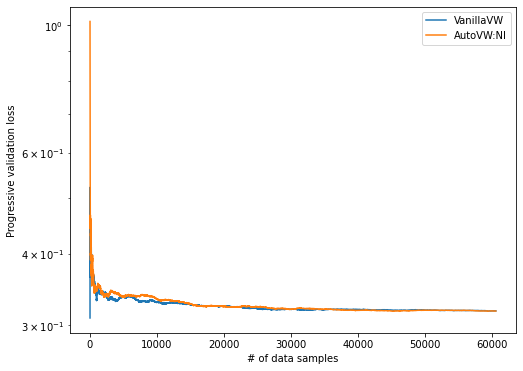

In [118]:
import matplotlib.pyplot as plt
def plot_progressive_loss(obj_list, alias, result_interval=1):
    """Show real-time progressive validation loss
    """
    avg_list = [sum(obj_list[:i]) / i for i in range(1, len(obj_list))]
    total_obs = len(avg_list)
    warm_starting_point = 10 #0
    plt.plot(range(warm_starting_point, len(avg_list)), avg_list[warm_starting_point:], label = alias)
    plt.xlabel('# of data samples',)
    plt.ylabel('Progressive validation loss')
    plt.yscale('log')
    plt.legend(loc='upper right')
plt.figure(figsize=(8, 6))
plot_progressive_loss(loss_list_vanilla, 'VanillaVW')
plot_progressive_loss(loss_list_autovw_ni, 'AutoVW:NI')
plt.show()

In [123]:
y_pred = []
for i in range(X_test.shape[0]):
    ex = get_test_example(X_test[i])
    y_pred.append(autovw_ni.predict(ex))

In [124]:
from sklearn.metrics import  r2_score, mean_absolute_error , mean_squared_error
print(f"R2  : {r2_score(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")

R2  : 0.04012210502131974
MAE : 0.4114179295286657
MSE: 0.3136059579235133


In [125]:
from sklearn.metrics import  r2_score, mean_absolute_error , mean_squared_error
print(f"R2  : {r2_score(y_test, y_pred)}")
print(f"MAE : {mean_absolute_error(y_test, y_pred)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")

R2  : 0.04012210502131974
MAE : 0.4114179295286657
MSE: 0.3136059579235133


/home/krishna/miniconda3/envs/interactive-learning/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/krishna/miniconda3/envs/interactive-learning/lib/python3.8/site-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/home/krishna/miniconda3/envs/interactive-learning/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level fu

Text(0.5, 1.0, 'Online Regression')

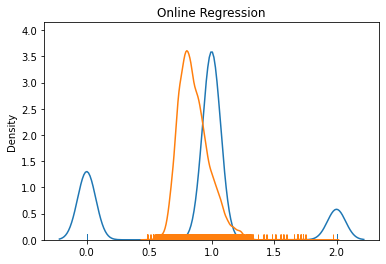

In [126]:

sns.distplot(y_test, hist=False, rug=True)
sns.distplot(y_pred, hist=False, rug=True)
plt.title("Online Regression")